In [1]:
import torch
import scvi
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

Global seed set to 0
/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/umap/__init__.py:11: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  category=ImportWarning,


scanpy==1.9.1 anndata==0.7.6 umap==0.5.3 numpy==1.19.4 scipy==1.6.2 pandas==1.3.3 scikit-learn==0.23.2 statsmodels==0.11.1 pynndescent==0.5.5


## Data

Dataset curation at https://github.com/theislab/sc-pert/blob/main/datasets/Frangieh_2021.ipynb

In [53]:
# this dataset has already been filtered, and cells were removed which did not have
# a unique guide label as done in the original paper
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/sc-pert/datasets/Norman_2019.h5ad')
# adata.obs['perturbation_name'] = ['_'.join(s.split('_')[:-1]) for s in adata.obs.sgRNA] # redo the dataset label for Frangieh because I wrote the regex wrong
adata

AnnData object with n_obs × n_vars = 111255 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', '

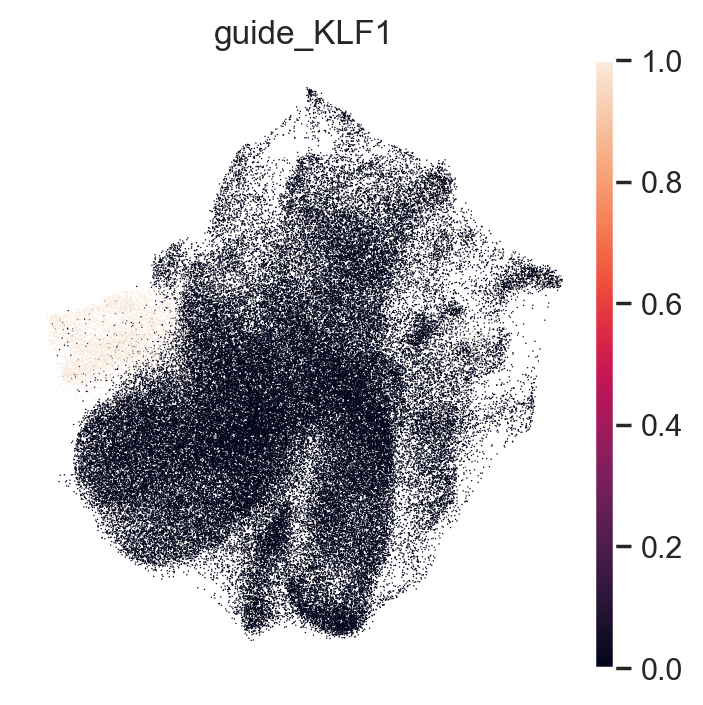

In [58]:
sc.pl.umap(adata, color=['guide_KLF1'])

Subset to the control condition to avoid additional confounders to perturbation effect. It might be interesting to investigate the effects of IFNg treatment on feature attribution at a later date, but we'll leave it for now.

In [4]:
adata = adata[adata.obs.perturbation_name.isin(len([x for x in adata.obs.perturbation_name.value_counts().index if '+' not in x]))]

In [5]:
sound_labels = adata.obs.perturbation_name.value_counts()[adata.obs.perturbation_name.value_counts() > 100].index
len(sound_labels)

176

In [6]:
missing_var = set(sound_labels) - set(adata.var_names)
missing_var

{'APOC2',
 'GAS5',
 'HLA-H',
 'LEF1-AS1',
 'LRRC75A-AS1',
 'NO_SITE',
 'NUP50-AS1',
 'ONE_NON-GENE_SITE',
 'SLC7A5P1',
 'SNHG6',
 'TYR',
 'WNT7A'}

164 out of 176. With the exception of WNT7A which was filtered out due to low expression levels, the other genes do not match those in `var_names` for various annotation regions.

Since we can't use these samples for feature attribution, we'll use them as a test set.

TODO: save this filtered dataset in a shared workspace directory

In [7]:
adata = adata[adata.obs.perturbation_name.isin(sound_labels)].copy()

TODO: set some kind of test split.

In [ ]:
# adata.obs['split'][adata.obs.perturbation_name] = 

## Train

TODO: do 5 training runs with different seeds and 5 runs with dataloader shuffling.

In [8]:
import scgen

In [10]:
# example: scgen.SCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")
scgen.SCGEN.setup_anndata(adata, batch_key='perturbation_name')

In [11]:
model = scgen.SCGEN(adata)
model.module

SCGENVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=22097, out_features=800, bias=True)
          (1): BatchNorm1d(800, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.2, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=800, out_features=800, bias=True)
          (1): BatchNorm1d(800, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=800, out_features=100, bias=True)
    (var_encoder): Linear(in_features=800, out_features=100, bias=True)
  )
  (decoder): DecoderSCGEN(
    (decoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequentia

Parameters taken from the scGen tutorial.

TODO: switch to GPU for actual training runs.

In [12]:
model.train(
    max_epochs=250,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/torch/distributed/_sharded_tensor/__init__.py:10: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  DeprecationWarning
/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potent

Epoch 6/100:   5%|████████▊                                                                                                                                                                       | 5/100 [05:48<1:49:51, 69.39s/it, loss=1.68e+04, v_num=1]

/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


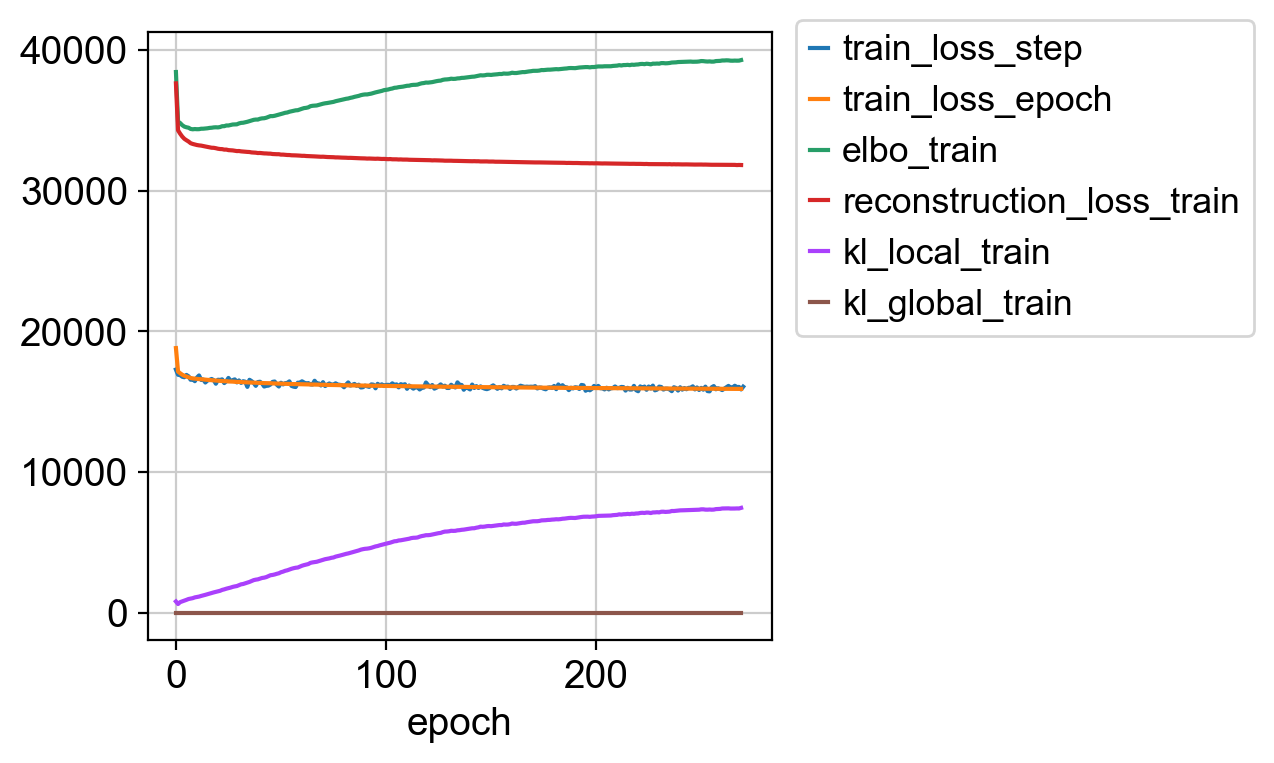

In [58]:
pd.concat(model.history.values(), axis=1).plot()
plt.legend(bbox_to_anchor=(1.01, 1.05));

Save the model.

In [13]:
model.save("../models/scgen_frangi21.pt", overwrite=True)

## Quality control

potential todo: loop over multiple models here.

Latent space visualization.

In [14]:
latent_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())

In [15]:
latent_adata

AnnData object with n_obs × n_vars = 26842 × 100
    obs: 'library_preparation_protocol', 'condition', 'MOI', 'sgRNA', 'UMI_count', 'n_genes', 'leiden', 'perturbation_name', 'perturbation_type', 'perturbation_value', 'perturbation_unit', '_scvi_batch', '_scvi_labels'

In [16]:
%%time
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/umap/spectral.py:349: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


CPU times: user 49.5 s, sys: 14.3 s, total: 1min 3s
Wall time: 41.4 s


TODO: color these points

In [18]:
adata.obs.perturbation_name.value_counts().head(5)

NO_SITE              2189
ONE_NON-GENE_SITE    1581
NT5E                  177
CTSD                  169
TSC22D3               169
Name: perturbation_name, dtype: int64

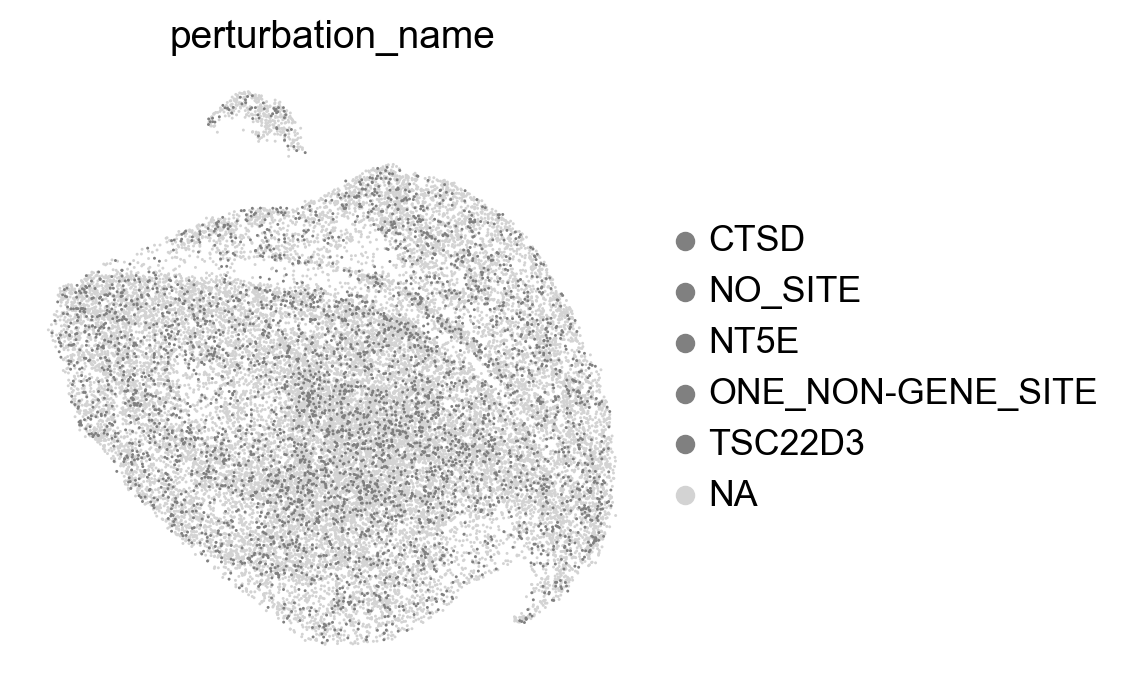

In [17]:
sc.pl.umap(latent_adata, color='perturbation_name', groups=list(adata.obs.perturbation_name.value_counts().index[:5]), cmap='tab20')

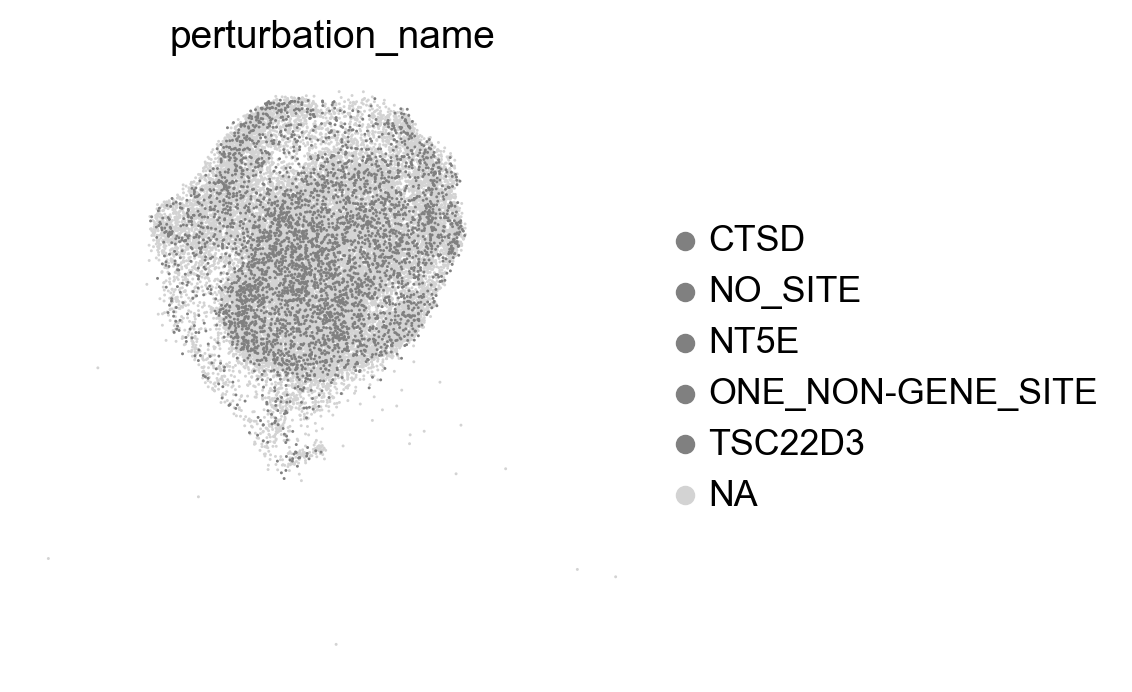

In [19]:
sc.pl.umap(adata, color='perturbation_name', groups=list(adata.obs.perturbation_name.value_counts().index[:5]), cmap='tab20')

### Mean correlations

(Standard evaluation metrics, but no test set.)

In [20]:
example_pert = 'NT5E'  # condition with the most occurrences

(One could consider using both NO_SITE and ONE_NON-GENE_SITE here.)

In [21]:
%%time
sc.tl.rank_genes_groups(adata, groupby='perturbation_name', reference='NO_SITE', method='wilcoxon')

/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]


CPU times: user 6min 19s, sys: 1min 25s, total: 7min 45s
Wall time: 7min 46s


In [23]:
diff_genes = adata.uns['rank_genes_groups']['names'][example_pert]
print(diff_genes[:10])

['GNG11' 'MMP1' 'FASN' 'AAMP' 'ATP5MC3' 'COX6A1' 'GPX4' 'LAMTOR5' 'LARP6'
 'LSM5']


In [35]:
ctrl_adata = adata[adata.obs.perturbation_name.isin(['NO_SITE', example_pert])]
pred, delta = model.predict(
    ctrl_key='NO_SITE',
    stim_key=example_pert,
    adata_to_predict=adata[adata.obs.perturbation_name == 'NO_SITE'].copy()  # strange implementation but ok
)
pred.obs['perturbation_name'] = 'pred'

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                  


In [46]:
eval_adata = pred.concatenate(ctrl_adata)[:, diff_genes[:100]]

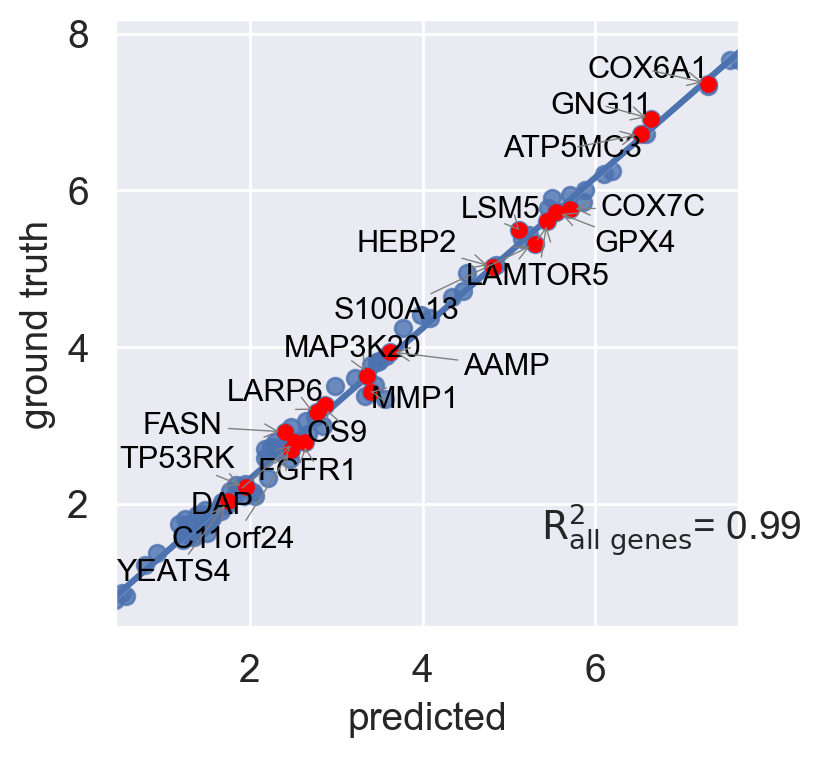

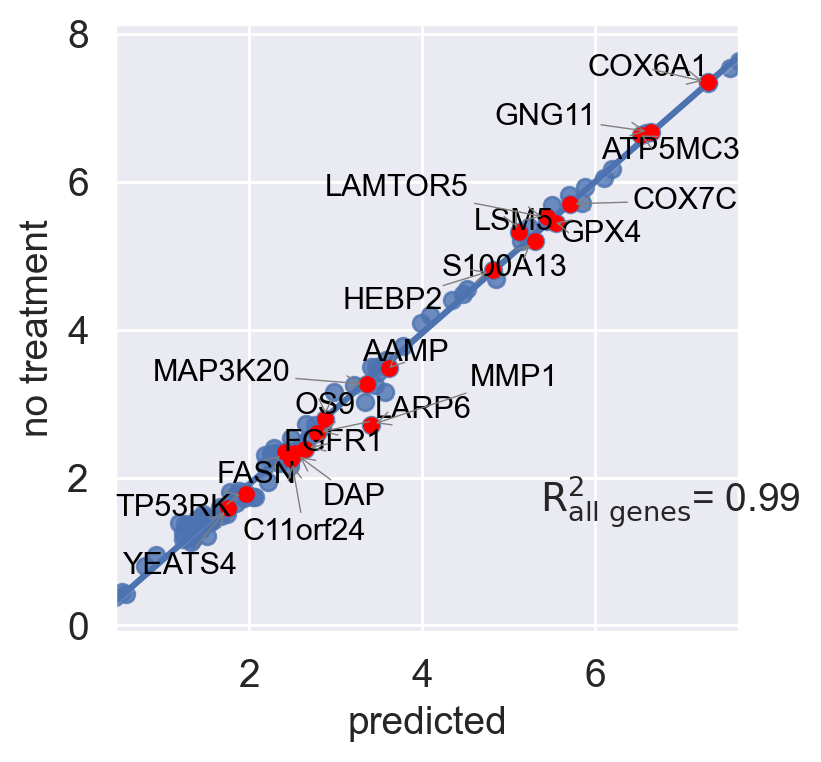

In [47]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': 'pred', 'y': example_pert},
    gene_list=diff_genes[:20],
    labels={'x': 'predicted', 'y': 'ground truth'},
    show=True,
    legend=False
)
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': 'pred', 'y': 'NO_SITE'},
    gene_list=diff_genes[:20],
    labels={'x': 'predicted', 'y': 'no treatment'},
    show=True,
    legend=False
)

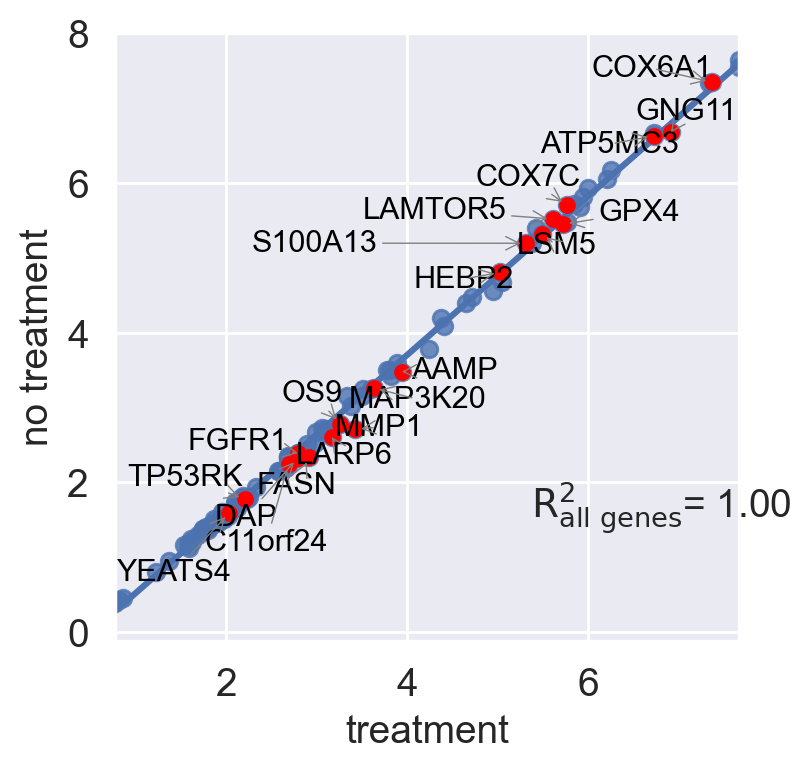

In [48]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': example_pert, 'y': 'NO_SITE'},
    gene_list=diff_genes[:20],
    labels={'x': 'treatment', 'y': 'no treatment'},
    show=True,
    legend=False
)

This data is kind of abysmal. How did MIMOSCA manage to pick out "responding" cells?

TODO: loop over all conditions to get an overall score